In [ ]:
# Cài đặt thư viện cần thiết
!pip install transformers pandas scikit-learn nltk rouge-score tqdm

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=217752eee5411925c28802a36538318f75f3594b34a5b698d9848055c4f7bd0b
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

In [ ]:
# Import thư viện
import pandas as pd
import numpy as np
import torch
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq
)
from sklearn.model_selection import train_test_split
from datasets import Dataset
import nltk
from nltk.tokenize import sent_tokenize
from rouge_score import rouge_scorer
import os
from google.colab import drive
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


In [ ]:
# Kết nối với Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Tải dataset từ Google Drive
csv_path = '/content/drive/MyDrive/project_02/five_Thousand_dataset.csv'  # Điều chỉnh đường dẫn phù hợp với vị trí lưu trữ của bạn
df = pd.read_csv(csv_path)
print(f"Dataset shape: {df.shape}")
print(df.head())

Dataset shape: (5000, 2)
                                            Contents  \
0  những ngày vừa qua, trên trang facebook chính ...   
1  theo thông tin từ cục thuế tp. hcm, hiện cơ qu...   
2  cnlđ mong muốn sớm được tiếp cận với nhà ở xã ...   
3  hoàn công nhà ở là một thủ tục hành chính tron...   
4  đi dọc đường lê văn lương kéo dài xuống khu dư...   

                                             Summary  
0  lâm đồng  lãnh đạo thành phố bảo lộc, lâm đồng...  
1  tphcm  việc không thể cưỡng chế thuế của hai d...  
2  hiện trên địa bàn tỉnh ninh bình có 32 khu, cụ...  
3  hoàn công nhà ở với ý nghĩa là điều kiện để đư...  
4  có rất nhiều lý do khiến những dự án thấp nội ...  


In [ ]:
# Kiểm tra và xử lý dữ liệu missing
print("\nKiểm tra dữ liệu missing:")
print(df.isnull().sum())

# Xử lý dữ liệu missing nếu có
df = df.dropna()
print(f"Dataset shape sau khi xử lý missing: {df.shape}")


Kiểm tra dữ liệu missing:
Contents    0
Summary     0
dtype: int64
Dataset shape sau khi xử lý missing: (5000, 2)


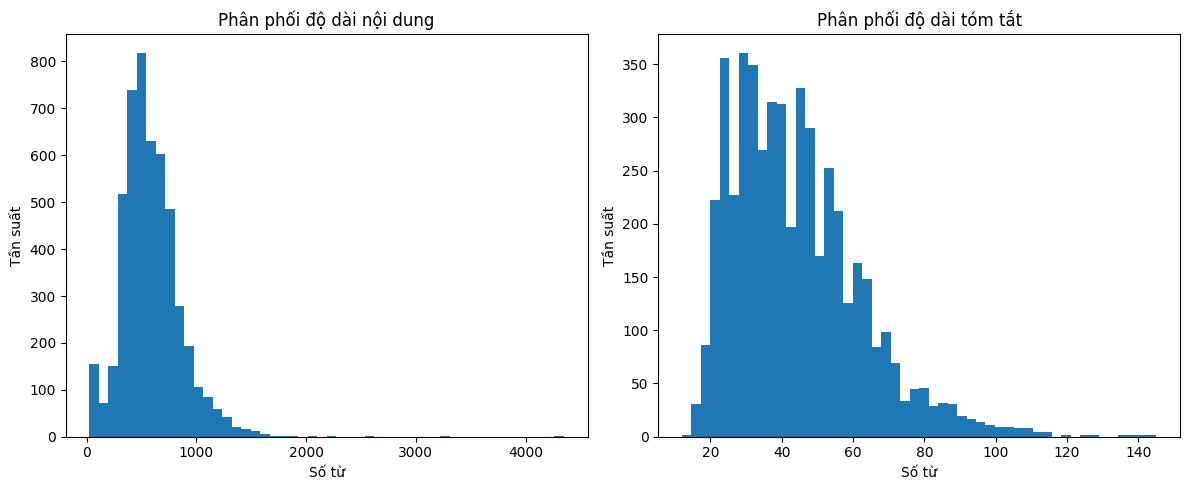

Độ dài trung bình của nội dung: 587.39 từ
Độ dài trung bình của tóm tắt: 44.18 từ
Độ dài tối đa của nội dung: 4348 từ
Độ dài tối đa của tóm tắt: 145 từ


In [ ]:
# Kiểm tra độ dài của contents và summary
df['content_length'] = df['Contents'].apply(lambda x: len(x.split()))
df['summary_length'] = df['Summary'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df['content_length'], bins=50)
plt.title('Phân phối độ dài nội dung')
plt.xlabel('Số từ')
plt.ylabel('Tần suất')

plt.subplot(1, 2, 2)
plt.hist(df['summary_length'], bins=50)
plt.title('Phân phối độ dài tóm tắt')
plt.xlabel('Số từ')
plt.ylabel('Tần suất')
plt.tight_layout()
plt.show()

print(f"Độ dài trung bình của nội dung: {df['content_length'].mean():.2f} từ")
print(f"Độ dài trung bình của tóm tắt: {df['summary_length'].mean():.2f} từ")
print(f"Độ dài tối đa của nội dung: {df['content_length'].max()} từ")
print(f"Độ dài tối đa của tóm tắt: {df['summary_length'].max()} từ")


In [ ]:
# Xử lý dữ liệu có độ dài quá lớn (nếu cần thiết)
max_content_length = 512  # Giới hạn độ dài nội dung
max_summary_length = 128  # Giới hạn độ dài tóm tắt

df = df[df['content_length'] <= max_content_length]
df = df[df['summary_length'] <= max_summary_length]
print(f"Dataset shape sau khi xử lý độ dài: {df.shape}")


Dataset shape sau khi xử lý độ dài: (2193, 4)


In [ ]:
# Chia dữ liệu thành tập train, validation, test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

print(f"Train set: {train_df.shape[0]} samples")
print(f"Validation set: {val_df.shape[0]} samples")
print(f"Test set: {test_df.shape[0]} samples")

Train set: 1578 samples
Validation set: 176 samples
Test set: 439 samples


In [ ]:
# Chuẩn bị dữ liệu cho mô hình
def prepare_dataset(df):
    return Dataset.from_pandas(df[['Contents', 'Summary']])

train_dataset = prepare_dataset(train_df)
val_dataset = prepare_dataset(val_df)
test_dataset = prepare_dataset(test_df)

In [ ]:
# Tải mô hình và tokenizer
model_name = "VietAI/vit5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/820k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.12k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/904M [00:00<?, ?B/s]

In [ ]:
# Cấu hình tokenizer
prefix = "tóm tắt: "

In [ ]:
# Tiền xử lý dữ liệu
def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["Contents"]]
    model_inputs = tokenizer(inputs, max_length=max_content_length, truncation=True, padding="max_length")

    # Tokenize targets
    labels = tokenizer(
        examples["Summary"],
        max_length=max_summary_length,
        truncation=True,
        padding="max_length"
    )

    model_inputs["labels"] = labels["input_ids"]

    # Replace padding token id's with -100 so they are not included in loss computation
    model_inputs["labels"] = [
        [-100 if token == tokenizer.pad_token_id else token for token in label]
        for label in model_inputs["labels"]
    ]

    return model_inputs

In [ ]:
# Áp dụng tiền xử lý
train_dataset = train_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=["Contents", "Summary"]
)

val_dataset = val_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=["Contents", "Summary"]
)

test_dataset = test_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=["Contents", "Summary"]
)

Map:   0%|          | 0/1578 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/904M [00:00<?, ?B/s]

Map:   0%|          | 0/176 [00:00<?, ? examples/s]

Map:   0%|          | 0/439 [00:00<?, ? examples/s]

In [ ]:
# Cài đặt thêm thư viện cần thiết nếu chưa có
!pip install evaluate

# Import Seq2SeqTrainingArguments thay vì TrainingArguments
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    Seq2SeqTrainingArguments,  # Thay thế TrainingArguments
    Seq2SeqTrainer,  # Thay thế Trainer
    DataCollatorForSeq2Seq
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.0 MB/s eta 0:00:00


In [ ]:
# Cấu hình huấn luyện
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=False,
    report_to="none",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=100,
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    pad_to_multiple_of=8 if training_args.fp16 else None,
)

In [ ]:
# Thiết lập huấn luyện với Seq2SeqTrainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

<ipython-input-22-f7cf3f329894>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
# Huấn luyện mô hình
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,2.169400,1.645073
2,1.530800,1.596696
3,1.298300,1.620075


TrainOutput(global_step=594, training_loss=1.603132254346854, metrics={'train_runtime': 484.3008, 'train_samples_per_second': 9.775, 'train_steps_per_second': 1.227, 'total_flos': 2882806653911040.0, 'train_loss': 1.603132254346854, 'epoch': 3.0})

In [ ]:
# Đánh giá mô hình sử dụng ROUGE
nltk.download('punkt')
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def compute_metrics(model, tokenizer, dataset, batch_size=8):
    all_references = []
    all_predictions = []

    for i in tqdm(range(0, len(dataset), batch_size)):
        batch = dataset[i:i+batch_size]

        # Lấy nội dung gốc từ input_ids
        input_text = tokenizer.batch_decode(
            batch["input_ids"],
            skip_special_tokens=True,
            clean_up_tokenization_spaces=True
        )

        # Lấy tóm tắt thực tế từ labels
        references = []
        for label_ids in batch["labels"]:
            label = [id for id in label_ids if id != -100]
            reference = tokenizer.decode(label, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            references.append(reference)

        # Dự đoán tóm tắt
        input_ids = torch.tensor(batch["input_ids"]).to(model.device)
        outputs = model.generate(
            input_ids,
            max_length=max_summary_length,
            num_beams=4,
            early_stopping=True
        )
        predictions = tokenizer.batch_decode(outputs, skip_special_tokens=True, clean_up_tokenization_spaces=True)

        all_references.extend(references)
        all_predictions.extend(predictions)

    # Tính toán ROUGE scores
    rouge_scores = {
        'rouge1': [],
        'rouge2': [],
        'rougeL': []
    }

    for ref, pred in zip(all_references, all_predictions):
        if len(ref) > 0 and len(pred) > 0:
            scores = scorer.score(ref, pred)
            rouge_scores['rouge1'].append(scores['rouge1'].fmeasure)
            rouge_scores['rouge2'].append(scores['rouge2'].fmeasure)
            rouge_scores['rougeL'].append(scores['rougeL'].fmeasure)

    # Tính trung bình
    results = {
        'rouge1': np.mean(rouge_scores['rouge1']),
        'rouge2': np.mean(rouge_scores['rouge2']),
        'rougeL': np.mean(rouge_scores['rougeL'])
    }

    return results, all_references, all_predictions


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Đánh giá trên tập test
print("Đánh giá mô hình trên tập test...")
results, references, predictions = compute_metrics(model, tokenizer, test_dataset)

print(f"ROUGE-1: {results['rouge1']:.4f}")
print(f"ROUGE-2: {results['rouge2']:.4f}")
print(f"ROUGE-L: {results['rougeL']:.4f}")

# Hiển thị một số ví dụ
print("\nMột số ví dụ từ tập test:")
for i in range(min(5, len(references))):
    original_text = test_df.iloc[i]["Contents"]
    print(f"\nVăn bản gốc: {original_text[:200]}...")
    print(f"Tóm tắt thực tế: {references[i]}")
    print(f"Tóm tắt dự đoán: {predictions[i]}")


Đánh giá mô hình trên tập test...


  0%|          | 0/55 [00:00<?, ?it/s]

ROUGE-1: 0.5612
ROUGE-2: 0.2946
ROUGE-L: 0.3854

Một số ví dụ từ tập test:

Văn bản gốc: bộ tài chính vừa ban hành thông tư 1002021 sửa đổi, bổ sung thông tư 402021 hướng dẫn thuế giá trị gia tăng, thuế thu nhập cá nhân và quản lý thuế đối với hộ, cá nhân kinh doanh. theo đó, sửa đổi điểm...
Tóm tắt thực tế: bộ tài chính đã có thay đổi cách xác định doanh thu tính thuế đối với người cho thuê tài sản, thuê nhà. theo đó, người cho thuê tài sản, thuê nhà trong năm có doanh thu dưới 100 triệu đồng không phải đóng thuế.
Tóm tắt dự đoán: bộ tài chính vừa ban hành thông tư 1002021 sửa đổi, bổ sung thông tư 402021 hướng dẫn thuế giá trị gia tăng, thuế thu nhập cá nhân và quản lý thuế đối với hộ, cá nhân kinh doanh.

Văn bản gốc: tòa căn hộ sa2 thuộc phân khu the sakura  sản phẩm bất động sản đẳng cấp kết hợp giữa hai thương hiệu uy tín hàng đầu việt nam và nhật bản là vinhomes và samty corporation. tòa nhà được thiết kế linh ...
Tóm tắt thực tế: công ty cổ phần vinhomes vừa chính thức mở bán t

In [ ]:
# Điều chỉnh tham số mô hình với các siêu tham số mới
print("\nHuấn luyện lại mô hình với siêu tham số được điều chỉnh...")

# Cấu hình huấn luyện mới
improved_training_args = Seq2SeqTrainingArguments(
    output_dir="./improved_results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=5,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=False,
    report_to="none",
    save_strategy="epoch",
    logging_dir="./improved_logs",
    logging_steps=100,
    gradient_accumulation_steps=2,
    warmup_steps=100,
)


Huấn luyện lại mô hình với siêu tham số được điều chỉnh...


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Thiết lập huấn luyện lại
improved_trainer = Seq2SeqTrainer(
    model=model,
    args=improved_training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

<ipython-input-27-f1e66c25e324>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  improved_trainer = Seq2SeqTrainer(


In [ ]:
# Huấn luyện lại mô hình
improved_trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,1.725977
2,0.983200,1.747215
3,0.894800,1.702440
4,0.979500,1.723410
5,1.041500,1.739368


TrainOutput(global_step=495, training_loss=0.9777900310477825, metrics={'train_runtime': 791.7363, 'train_samples_per_second': 9.965, 'train_steps_per_second': 0.625, 'total_flos': 4804677756518400.0, 'train_loss': 0.9777900310477825, 'epoch': 5.0})

In [ ]:
# Đánh giá mô hình cải tiến
print("Đánh giá mô hình cải tiến trên tập test...")
improved_results, improved_references, improved_predictions = compute_metrics(model, tokenizer, test_dataset)

print(f"ROUGE-1 (cải tiến): {improved_results['rouge1']:.4f}")
print(f"ROUGE-2 (cải tiến): {improved_results['rouge2']:.4f}")
print(f"ROUGE-L (cải tiến): {improved_results['rougeL']:.4f}")

Đánh giá mô hình cải tiến trên tập test...


  0%|          | 0/55 [00:00<?, ?it/s]

ROUGE-1 (cải tiến): 0.5718
ROUGE-2 (cải tiến): 0.2892
ROUGE-L (cải tiến): 0.3871


In [ ]:
# So sánh kết quả
print("\nSo sánh kết quả:")
print(f"ROUGE-1: {results['rouge1']:.4f} -> {improved_results['rouge1']:.4f}")
print(f"ROUGE-2: {results['rouge2']:.4f} -> {improved_results['rouge2']:.4f}")
print(f"ROUGE-L: {results['rougeL']:.4f} -> {improved_results['rougeL']:.4f}")



So sánh kết quả:
ROUGE-1: 0.5612 -> 0.5718
ROUGE-2: 0.2946 -> 0.2892
ROUGE-L: 0.3854 -> 0.3871


In [ ]:
# Lưu mô hình
model_save_path = '/content/drive/MyDrive/best_vit5_summarization_model'
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Đã lưu mô hình tại: {model_save_path}")


Đã lưu mô hình tại: /content/drive/MyDrive/best_vit5_summarization_model


In [ ]:
# Hàm tóm tắt văn bản mới
def summarize_text(text, model, tokenizer, max_length=128):
    inputs = tokenizer("tóm tắt: " + text, return_tensors="pt", max_length=512, truncation=True)
    inputs = inputs.to(model.device)

    outputs = model.generate(
        inputs.input_ids,
        max_length=max_length,
        num_beams=4,
        early_stopping=True
    )

    summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return summary


In [ ]:
# Thử nghiệm mô hình với văn bản mới
print("\nThử nghiệm mô hình với văn bản mới:")

# Ví dụ văn bản mới
new_texts = [
    "Khoa học là một hệ thống kiến thức về những định luật,... cấu trúc và cách vận hành của thế giới tự nhiên, được đúc kết qua từng giai đoạn lịch sử thông qua việc quan sát, mô tả, đo đạc, thực nghiệm, phát triển lý thuyết bằng các phương pháp khoa học."

]

for i, text in enumerate(new_texts):
    print(f"\nVăn bản {i+1}: {text[:200]}...")
    summary = summarize_text(text, model, tokenizer)
    print(f"Tóm tắt: {summary}")


Thử nghiệm mô hình với văn bản mới:

Văn bản 1: Khoa học là một hệ thống kiến thức về những định luật, cấu trúc và cách vận hành của thế giới tự nhiên, được đúc kết qua từng giai đoạn lịch sử thông qua việc quan sát, mô tả, đo đạc, thực nghiệm, phá...
Tóm tắt: khoa học là một hệ thống kiến thức về những định luật, cấu trúc và cách vận hành của thế giới tự nhiên, được đúc kết qua từng giai đoạn lịch sử.


Demo model trên Colab

In [ ]:
# Cài đặt các thư viện cần thiết
!pip install transformers torch gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch
import gradio as gr
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [ ]:
# Đường dẫn đến thư mục model trên Google Drive
model_path = "/content/drive/MyDrive/best_vit5_summarization_model"

In [ ]:
# Nạp tokenizer và model
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
model.eval()

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


T5ForConditionalGeneration(
  (shared): Embedding(36096, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(36096, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [ ]:
# Định nghĩa hàm tóm tắt
def summarize_text(text, max_length=150, min_length=50):
    # Mã hóa văn bản đầu vào
    inputs = tokenizer(
        text,
        max_length=512, # Giới hạn độ dài tối đa của văn bản đầu vào (tính bằng token)
        padding=True,  # Thêm padding (các token 0) để đảm bảo các tensor có cùng kích thước -> xử lý hiệu quả khi xử lý các văn bản có độ dài khác nhau
        truncation=True,  # Cắt bớt văn bản nếu vượt quá max_length -> Đảm bảo văn bản không bị tràn bộ nhớ
        return_tensors="pt" # Chuyển đổi đầu ra sang tensor của PyTorch -> Chuẩn bị dữ liệu để đưa vào mô hình
    )

    # Sinh tóm tắt với các tham số nâng cao
    summary_ids = model.generate(
        inputs['input_ids'],
        max_length=max_length,  # Độ dài tối đa của văn bản tóm tắt (tính bằng token)
        min_length=min_length,  # Độ dài tối thiểu của văn bản tóm tắt (tính bằng token)
        num_beams=8,            #  Số lượng beam trong beam search - kỹ thuật tìm kiếm các giải pháp tốt nhất
        num_return_sequences=1, # Số lượng chuỗi (tóm tắt) được sinh ra
        temperature=0.7,         # Điều chỉnh độ ngẫu nhiên của văn bản ((gần 0): Văn bản chính xác, ít sáng tạo; (gần 1): Văn bản đa dạng, nhưng có thể kém chính xác)
        top_k=50,               # Lọc top k token có xác suất cao nhất, chỉ xem xét 50 token có xác suất cao nhất
        top_p=0.95,               # Chọn các token có tổng xác suất tích lũy dưới 0.95, ngăn việc chọn quá nhiều token có xác suất thấp
        no_repeat_ngram_size=3,  # Tránh lặp các cụm từ 3 từ trở lên
        early_stopping=True       # Dừng sinh văn bản sớm nếu đã tìm được giải pháp tóm tắt tối ưu
    )

    # Giải mã tóm tắt
    summary = tokenizer.decode(
        summary_ids[0],
        skip_special_tokens=True,
        clean_up_tokenization_spaces=True
    )

    return summary

In [ ]:
# Ví dụ sử dụng
input_text = """Biến đổi khí hậu đang là vấn đề toàn cầu nghiêm trọng. Trong những năm gần đây, nhiệt độ trái đất tăng liên tục, gây ra những hậu quả môi trường nghiêm trọng. Các nhà khoa học đã ghi nhận sự tan chảy của sông băng, mực nước biển dâng cao, và những thay đổi bất thường về thời tiết. Các quốc gia trên thế giới đang nỗ lực giảm phát thải carbon, phát triển năng lượng sạch, và áp dụng các giải pháp công nghệ để hạn chế tác động của biến đổi khí hậu."""

# Sinh tóm tắt
summary = summarize_text(input_text)

print("Văn bản gốc:")
print(input_text)
print("\nTóm tắt:")
print(summary)

Văn bản gốc:
Biến đổi khí hậu đang là vấn đề toàn cầu nghiêm trọng. Trong những năm gần đây, nhiệt độ trái đất tăng liên tục, gây ra những hậu quả môi trường nghiêm trọng. Các nhà khoa học đã ghi nhận sự tan chảy của sông băng, mực nước biển dâng cao, và những thay đổi bất thường về thời tiết. Các quốc gia trên thế giới đang nỗ lực giảm phát thải carbon, phát triển năng lượng sạch, và áp dụng các giải pháp công nghệ để hạn chế tác động của biến đổi khí hậu.

Tóm tắt:
biến đổi khí hậu đang là vấn đề toàn cầu nghiêm trọng. Các nhà khoa học đang nỗ lực giảm phát thải carbon, phát triển năng lượng sạch, và áp dụng các giải pháp công nghệ để hạn chế tác động tiêu cực của nó.


In [ ]:
# Tạo giao diện Gradio
iface = gr.Interface(
    fn=summarize_text,
    inputs=[
        gr.Textbox(lines=10, placeholder="Nhập văn bản tiếng Việt cần tóm tắt..."),
        gr.Slider(minimum=50, maximum=300, value=150, label="Độ dài tóm tắt")
    ],
    outputs=gr.Textbox(lines=5, placeholder="Bản tóm tắt sẽ hiển thị ở đây..."),
    title="Mô Hình Tóm Tắt Văn Bản ViT5",
    description="Nhập văn bản tiếng Việt để nhận bản tóm tắt ngắn gọn"
)

# Chạy giao diện
iface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2ac61ec3a6f0b4f1d1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
